In [1]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential 
from keras.layers import Dense, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, RepeatVector 

In [2]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('agr.csv')

In [3]:
# Xử lý dữ liệu
prices = data['Price']

In [4]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))

In [5]:
scaled_prices

array([[0.15529524],
       [0.14823492],
       [0.14862937],
       ...,
       [0.54325843],
       [0.54525062],
       [0.54724281]])

In [6]:
#RATIO 73

In [7]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.7)
test_size = int(len(scaled_prices) * 0.3)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [8]:
test_data

array([[0.74509523],
       [0.74901984],
       [0.72548809],
       [0.69215475],
       [0.69607538],
       [0.7       ],
       [0.70980158],
       [0.70980158],
       [0.71764682],
       [0.72352777],
       [0.72548809],
       [0.71764682],
       [0.71176189],
       [0.69803968],
       [0.70196032],
       [0.69411507],
       [0.69215475],
       [0.69803968],
       [0.75294047],
       [0.72940872],
       [0.7274484 ],
       [0.70588095],
       [0.68823412],
       [0.63921428],
       [0.65882142],
       [0.64705953],
       [0.61764682],
       [0.56862698],
       [0.5274484 ],
       [0.52548809],
       [0.52548809],
       [0.52156746],
       [0.48039286],
       [0.49411507],
       [0.50588095],
       [0.50980158],
       [0.51372619],
       [0.5       ],
       [0.49411507],
       [0.45490079],
       [0.41764682],
       [0.44313491],
       [0.43725396],
       [0.40196032],
       [0.36862698],
       [0.37254761],
       [0.40392063],
       [0.409

In [9]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)


In [10]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [11]:
X_train.shape

(1011, 30, 1)

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
# 8. Define CNN-GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100

16/16 [==============================] - 2s 7ms/step - loss: 0.0289
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 8.5328e-04
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 5.8457e-04
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 4.8325e-04
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 4.3756e-04
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 4.1296e-04
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 4.2695e-04
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 4.5634e-04
Epoch 10/100
16/16 [==============================] - 0s 7ms/step - loss: 4.1022e-04
Epoch 11/100
16/16 [==============================] - 0s 7ms/step - loss: 3.8524e-04
Epoch 12/100
16/16 [==============================] - 0s 7ms/step - loss: 3.7372e

In [15]:
data.index


RangeIndex(start=0, stop=1488, step=1)

In [16]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(data) + 1,len(data) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

13/13 [==============================] - 0s 2ms/step
[[1489]
 [1490]
 [1491]
 [1492]
 [1493]
 [1494]
 [1495]
 [1496]
 [1497]
 [1498]
 [1499]
 [1500]
 [1501]
 [1502]
 [1503]
 [1504]
 [1505]
 [1506]
 [1507]
 [1508]
 [1509]
 [1510]
 [1511]
 [1512]
 [1513]
 [1514]
 [1515]
 [1516]
 [1517]
 [1518]]
1/1 [==============================] - 0s 255ms/step
[13556.442  13572.202  13832.289  13740.024  14629.443  15173.5
 15092.6455 15015.708  15190.451  15239.449  15678.534  15230.677
 15715.418  15911.065  16122.233  15023.555  15723.203  15426.669
 15590.973  15843.916  15616.987  15875.079  16911.883  16844.922
 17023.375  16615.621  16297.219  16320.527  16201.427  16030.075 ]


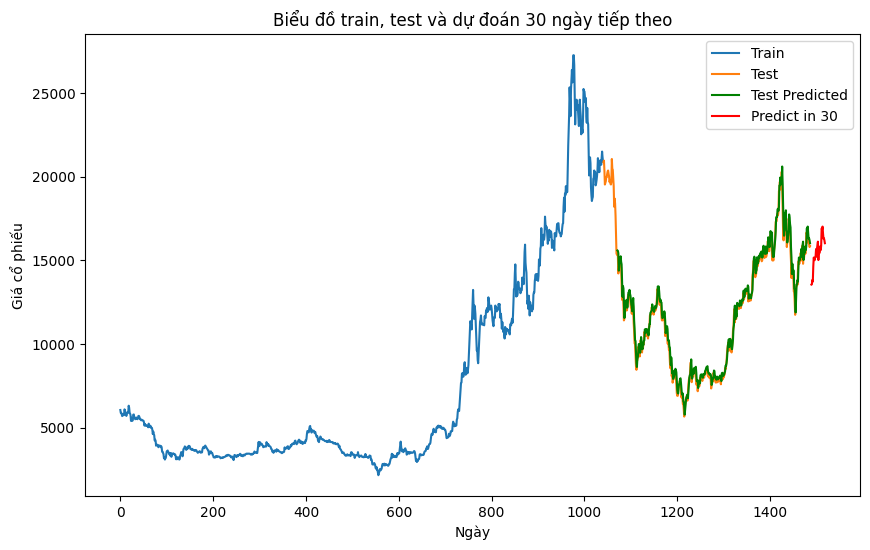

In [17]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict in 30')

plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Biểu đồ train, test và dự đoán 30 ngày tiếp theo')
plt.legend()
plt.show()

In [18]:
y_test_pred

array([[15596.579 ],
       [15575.627 ],
       [15431.397 ],
       [14392.015 ],
       [14744.491 ],
       [15089.209 ],
       [15134.26  ],
       [15247.252 ],
       [14919.165 ],
       [14770.788 ],
       [13795.74  ],
       [12830.701 ],
       [13465.391 ],
       [13325.2   ],
       [12375.896 ],
       [11561.832 ],
       [11656.777 ],
       [12447.08  ],
       [12586.24  ],
       [12564.59  ],
       [12648.277 ],
       [12172.335 ],
       [12250.891 ],
       [12766.174 ],
       [13096.276 ],
       [13038.788 ],
       [13241.752 ],
       [13022.414 ],
       [12905.066 ],
       [12672.842 ],
       [12361.286 ],
       [12255.033 ],
       [11962.696 ],
       [12339.291 ],
       [12755.877 ],
       [12248.989 ],
       [11412.455 ],
       [10945.151 ],
       [10228.224 ],
       [10186.185 ],
       [ 9532.332 ],
       [ 8851.512 ],
       [ 8633.192 ],
       [ 9107.655 ],
       [ 9215.761 ],
       [ 9518.173 ],
       [10000.05  ],
       [ 9982

In [19]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

# Tính MSLE cho testing
msle_test = mean_squared_log_error(y_test1, y_test_predicted, squared=False)




13/13 [==============================] - 0s 2ms/step


In [20]:
y_test1

array([[15354. ],
       [15255.6],
       [14222.2],
       [14566.6],
       [14861.9],
       [14960.3],
       [15058.8],
       [14714.3],
       [14566.6],
       [13582.4],
       [12647.4],
       [13287.1],
       [13139.5],
       [12253.7],
       [11417.1],
       [11515.5],
       [12302.9],
       [12450.5],
       [12450.5],
       [12499.8],
       [12007.6],
       [12106.1],
       [12598.2],
       [12942.7],
       [12893.5],
       [13090.3],
       [12844.2],
       [12745.8],
       [12499.8],
       [12204.5],
       [12106.1],
       [11810.8],
       [12204.5],
       [12598.2],
       [12106.1],
       [11269.5],
       [10777.4],
       [10039.2],
       [10039.2],
       [ 9340.4],
       [ 8690.8],
       [ 8464.4],
       [ 8976.2],
       [ 9054.9],
       [ 9389.6],
       [ 9842.3],
       [ 9793.1],
       [ 9822.6],
       [ 9261.6],
       [ 9645.5],
       [10236. ],
       [ 9990. ],
       [ 9645.5],
       [ 9497.8],
       [ 9842.3],
       [ 9

In [21]:
mape_test *= 100


print('---------TEST----------')
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("MSLE:", round(msle_test,3))
print('-------------------')


---------TEST----------
MAPE: 2.887
MAE: 325.398
RMSE: 434.346
MSLE: 0.037
-------------------
